In [1]:
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from pyDOE import lhs

Adjust cuda

In [2]:
if torch.cuda.is_available():
    device = torch.device ("cuda:0")
else:
    device = torch.device ("cpu")


torch.set_default_dtype(torch.float64)

print (f"Default devise: {device}")


Default devise: cuda:0


Prepare data

In [3]:
Re = 40
lmbda = 0.5 *(Re-np.sqrt(Re**2 + 16 * np.pi**2))

def v_x (x, y):
    Vx = 1 - np.exp(lmbda * x) * np.cos(2 * np.pi * y)
    return Vx
def v_y (x, y):
    Vy = (lmbda / (2 * np.pi)) * np.exp(lmbda * x) * np.sin(2 * np.pi * y)
    return Vy
def P (x, y):
    P = 0.5 * (1-np.exp(2*lmbda*x))
    return P

In [4]:
x_min, x_max = -0.5, 1.0
y_min, y_max = -0.5, 1.5
num_points = 1000 

x_domain = (torch.rand(num_points, 1) * (x_max - x_min) + x_min).to(device)
y_domain = (torch.rand(num_points, 1) * (y_max - y_min) + y_min).to(device)


In [5]:
num_outflow = 200
y_outflow = (torch.rand(num_outflow, 1) * (y_max - y_min) + y_min).to(device)
x_outflow = (torch.full_like(y_outflow, 1.0)).to(device)

In [6]:
num_inflow = 200  
y_inflow = (torch.rand(num_inflow, 1) * (y_max - y_min) + y_min).to(device)
x_inflow = (torch.full_like(y_inflow, -0.5)).to(device)  

In [7]:
def init_weight(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)

In [18]:
class PINN (nn.Module):
    def __init__ (self, n_hidden, n_neurons, activation, verbose = False):
        super().__init__ ()
        self.model = nn.Sequential ()
        self.build_NN (n_hidden, n_neurons, activation)
        self.model.to(device)


        if verbose:
            print (self.model)

        self.model.apply (init_weight)


    def build_NN (self,n_hidden, n_neurons, activation):
        self.model.add_module ('input layer',nn.Linear (2, n_neurons))
        self.model.add_module ('activation func', activation)

        for _ in range (n_hidden-1):
            self.model.add_module (f'hidden layer number: {_}', nn.Linear (n_neurons, n_neurons))
            self.model.add_module (f'activation func {_}', activation)

        self.model.add_module ('Output layer',nn.Linear (n_neurons, 3))

    def forward(self, x, y):
        
        input = torch.cat([x, y], dim=1)
        output = self.model(input)
        u, v, p = output[:, 0:1], output[:, 1:2], output[:, 2:3]
        return u, v, p



def compute_loss(model, Re, x_domain, y_domain, x_inflow, y_inflow, x_outflow, y_outflow):
    
    x_res = x_domain.requires_grad_(True)
    y_res = y_domain.requires_grad_(True)
    u, v, p = model(x_res, y_res)
    
    
    du_dx = torch.autograd.grad(u, x_res, torch.ones_like(u), create_graph=True)[0]
    du_dy = torch.autograd.grad(u, y_res, torch.ones_like(u), create_graph=True)[0]
    dv_dx = torch.autograd.grad(v, x_res, torch.ones_like(v), create_graph=True)[0]
    dv_dy = torch.autograd.grad(v, y_res, torch.ones_like(v), create_graph=True)[0]
    dp_dx = torch.autograd.grad(p, x_res, torch.ones_like(p), create_graph=True)[0]
    dp_dy = torch.autograd.grad(p, y_res, torch.ones_like(p), create_graph=True)[0]
    
    d2u_dx2 = torch.autograd.grad(du_dx, x_res, torch.ones_like(du_dx), create_graph=True)[0]
    d2u_dy2 = torch.autograd.grad(du_dy, y_res, torch.ones_like(du_dy), create_graph=True)[0]
    d2v_dx2 = torch.autograd.grad(dv_dx, x_res, torch.ones_like(dv_dx), create_graph=True)[0]
    d2v_dy2 = torch.autograd.grad(dv_dy, y_res, torch.ones_like(dv_dy), create_graph=True)[0]
    
    
    momentum_x = u * du_dx + v * du_dy + dp_dx - (1/Re) * (d2u_dx2 + d2u_dy2)
    momentum_y = u * dv_dx + v * dv_dy + dp_dy - (1/Re) * (d2v_dx2 + d2v_dy2)
    continuity = du_dx + dv_dy
    
    loss_res = torch.mean(momentum_x**2 + momentum_y**2 + continuity**2)
    
    
    u_inflow, v_inflow, p_inflow = model(x_inflow, y_inflow)
    u_inflow_true = 1 - torch.exp(x_inflow * lmbda) * torch.cos(2 * torch.pi * y_inflow)
    v_inflow_true = (lmbda / (2 * torch.pi)) * torch.exp(x_inflow * lmbda) * torch.sin(2 * torch.pi * y_inflow)
    p_inflow_true = 0.5 * (1- torch.exp (2*lmbda * x_inflow))
    loss_inflow = torch.mean((u_inflow - u_inflow_true)**2 + (v_inflow - v_inflow_true)**2 + (p_inflow-p_inflow_true)**2)
    
    
    _, _, p_outflow = model(x_outflow, y_outflow)
    p_outflow_true = 0.5 * (1- torch.exp (2*lmbda * x_outflow))
    loss_outflow = torch.mean((p_outflow - p_outflow_true)**2)
    
    
    x_periodic = torch.cat([x_domain, x_domain], dim=0)
    y_periodic = torch.cat([y_domain, y_domain - 2.0], dim=0) 
    u_periodic, v_periodic, _ = model(x_periodic, y_periodic)
    u_periodic_top, u_periodic_bottom = u_periodic.chunk(2)
    v_periodic_top, v_periodic_bottom = v_periodic.chunk(2)
    loss_periodic = torch.mean((u_periodic_top - u_periodic_bottom)**2 + (v_periodic_top - v_periodic_bottom)**2)
    
    
    total_loss = loss_res + loss_inflow + loss_outflow + loss_periodic
    return loss_res , loss_inflow, loss_outflow, loss_periodic, total_loss

In [19]:
import time

model = PINN(5, 50, nn.Tanh())
epochs = 10000

loss_bd_up = []
loss_bd_down = []
loss_init = []
loss_pde = []
total_loss_graph = []

optimizer = torch.optim.Adamax(model.parameters(), lr=1e-4, weight_decay=1e-5)

start_time = time.time()
for epoch in range(epochs):
    optimizer.zero_grad()

    loss_res , loss_inflow, loss_outflow, loss_periodic, total_loss = compute_loss (model, Re, x_domain, y_domain, x_inflow, y_inflow, x_outflow, y_outflow)

    loss_bd_up.append (loss_periodic.item())
    loss_bd_down.append (loss_outflow.item())
    loss_init.append (loss_inflow.item())
    loss_pde.append (loss_res.item())

    
    total_loss.backward()
    optimizer.step()
    if epoch%100 == 0:
        print(f"epoch: {epoch}, loss: {total_loss.item()}")
        print (f'Inital: {loss_inflow.item()}')
        print (f'bd  up: {loss_periodic.item()}')
        print (f'bd dowm: {loss_outflow.item()}')
        print (f'pde: {loss_res.item()}')

        total_loss_graph.append (total_loss.item())

end_time = time.time()
print (f'time: {end_time-start_time}')

model_save_path = f"model_flow_Re_40.pth"
torch.save(model.state_dict(), model_save_path)
with open("model_flow_Re_40.txt", 'w') as file:
    for elem in total_loss_graph:
        file.write(f"{elem}\n")

epoch: 0, loss: 2.939251866166669
Inital: 2.76355151909295
bd  up: 0.040136940073191525
bd dowm: 0.11992286608863087
pde: 0.01564054091189639
epoch: 100, loss: 1.9213922468908713
Inital: 1.6507328940949382
bd  up: 0.030239570227272885
bd dowm: 0.024641584486849437
pde: 0.21577819808181067
epoch: 200, loss: 1.6564462444664056
Inital: 1.4410810689805187
bd  up: 0.015014399490776579
bd dowm: 0.04041922897292095
pde: 0.1599315470221893
epoch: 300, loss: 1.631131565689371
Inital: 1.4182970678551723
bd  up: 0.01150774139599518
bd dowm: 0.04900919976739632
pde: 0.15231755667080732
epoch: 400, loss: 1.6266820614560147
Inital: 1.4153926240260728
bd  up: 0.010297541552886652
bd dowm: 0.049781821823894186
pde: 0.151210074053161
epoch: 500, loss: 1.623384713606017
Inital: 1.413863490822614
bd  up: 0.009652906610760592
bd dowm: 0.04965349064332734
pde: 0.1502148255293152
epoch: 600, loss: 1.6206684534642768
Inital: 1.4126418840009642
bd  up: 0.009281660952305728
bd dowm: 0.04945003986647256
pde: 0.

Visualization

In [20]:
u, v, p = model (x_domain, y_domain)

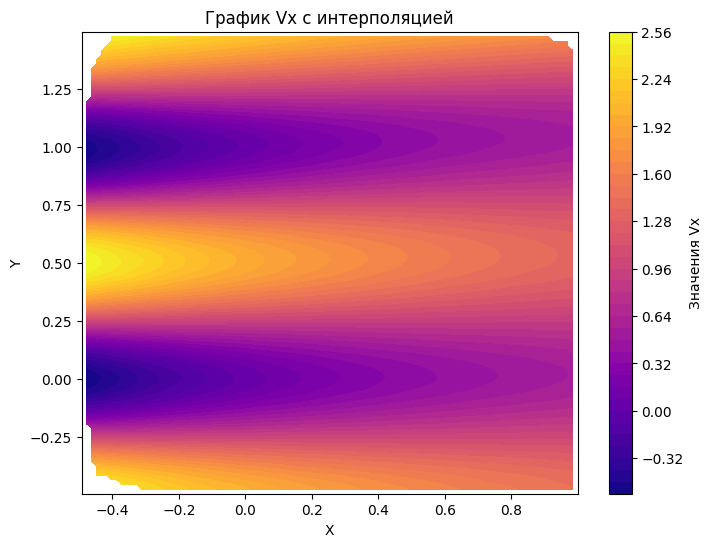

In [21]:
from scipy.interpolate import griddata

x_graph , y_graph = x_domain.cpu().detach().numpy(), y_domain.cpu().detach().numpy()
xi = np.linspace(x_graph.min(), x_graph.max(), 100)
yi = np.linspace(y_graph.min(), y_graph.max(), 100)
XI, YI = np.meshgrid(xi, yi)
# Интерполяция значений u на новой сетке
UI = griddata((x_graph.flatten(), y_graph.flatten()), u.cpu().detach().numpy().flatten(), (XI, YI), method='cubic')
# Создаем график с интерполированными данными
plt.figure(figsize=(8, 6))
contour = plt.contourf(XI, YI, UI, levels=50, cmap='plasma')
cbar = plt.colorbar(contour)
cbar.set_label('Значения Vx')
plt.title('График Vx с интерполяцией')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

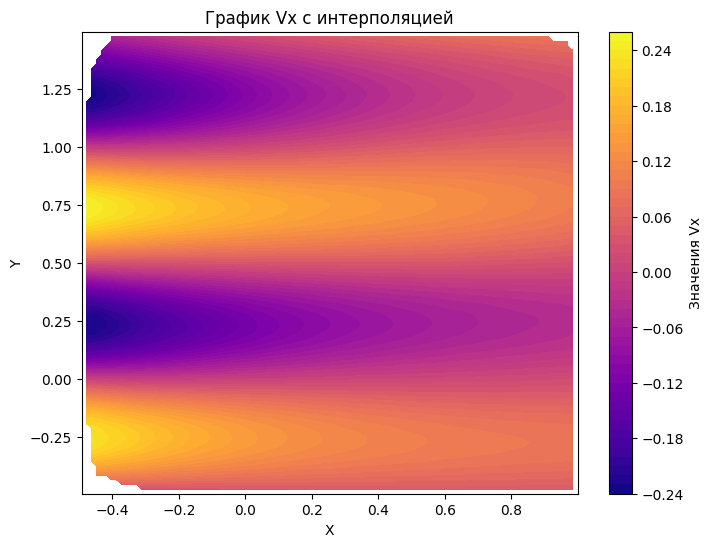

In [22]:
from scipy.interpolate import griddata

x_graph , y_graph = x_domain.cpu().detach().numpy(), y_domain.cpu().detach().numpy()
xi = np.linspace(x_graph.min(), x_graph.max(), 100)
yi = np.linspace(y_graph.min(), y_graph.max(), 100)
XI, YI = np.meshgrid(xi, yi)
# Интерполяция значений u на новой сетке
UI = griddata((x_graph.flatten(), y_graph.flatten()), v.cpu().detach().numpy().flatten(), (XI, YI), method='cubic')
# Создаем график с интерполированными данными
plt.figure(figsize=(8, 6))
contour = plt.contourf(XI, YI, UI, levels=50, cmap='plasma')
cbar = plt.colorbar(contour)
cbar.set_label('Значения Vx')
plt.title('График Vx с интерполяцией')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

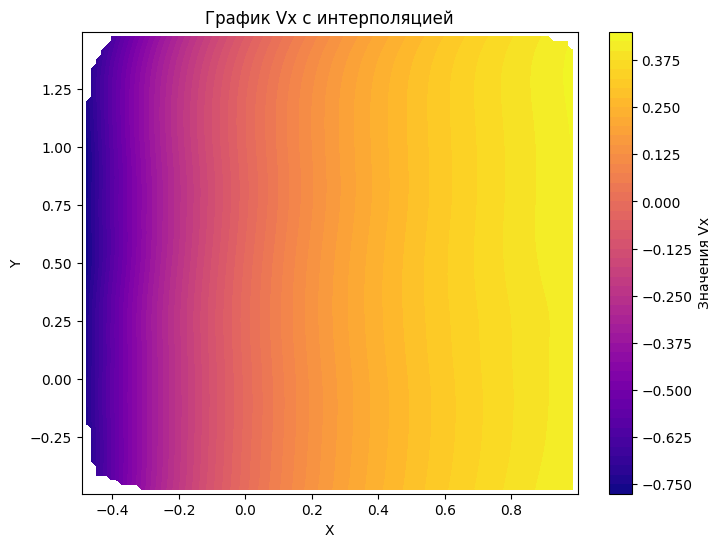

In [23]:
from scipy.interpolate import griddata

x_graph , y_graph = x_domain.cpu().detach().numpy(), y_domain.cpu().detach().numpy()
xi = np.linspace(x_graph.min(), x_graph.max(), 100)
yi = np.linspace(y_graph.min(), y_graph.max(), 100)
XI, YI = np.meshgrid(xi, yi)
# Интерполяция значений u на новой сетке
UI = griddata((x_graph.flatten(), y_graph.flatten()), p.cpu().detach().numpy().flatten(), (XI, YI), method='cubic')
# Создаем график с интерполированными данными
plt.figure(figsize=(8, 6))
contour = plt.contourf(XI, YI, UI, levels=50, cmap='plasma')
cbar = plt.colorbar(contour)
cbar.set_label('Значения Vx')
plt.title('График Vx с интерполяцией')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()